In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read, Stream

# Path dataset raw (ubah sesuai lokasimu)
input_root = r"E:\Skripsi\DEC\dataset\kating"
output_root = r"E:\Skripsi\DEC\dataset\ae-supervised-dataset\cleaned-3type"

# Panjang target (misalnya 3001 sample)
input_length = 3001

os.makedirs(output_root, exist_ok=True)


In [5]:
def count_short_samples(input_root, target_station, target_channel, min_length):
    """
    Hitung berapa banyak waveform dengan panjang < min_length.
    """
    short_count = 0
    total_count = 0
    lengths = []

    for filename in sorted(os.listdir(input_root)):
        if filename.endswith(".msd"):
            file_path = os.path.join(input_root, filename)
            st = read(file_path)

            for tr in st:
                if tr.stats.station == target_station and tr.stats.channel == target_channel:
                    total_count += 1
                    lengths.append(tr.stats.npts)
                    if tr.stats.npts < min_length:
                        short_count += 1

    print(f"Total traces ditemukan : {total_count}")
    print(f"Traces < {min_length}  : {short_count}")
    print(f"Traces >= {min_length} : {total_count - short_count}")
    return lengths

lengths = count_short_samples(input_root, target_station="MEPAS", target_channel="HHZ", min_length=input_length)


Total traces ditemukan : 4827
Traces < 3001  : 64
Traces >= 3001 : 4763


In [6]:
padding_counter = {"padded": 0}

def clean_trace(tr, input_length=3001):
    tr.detrend("linear")
    tr.filter("bandpass", freqmin=1, freqmax=15, zerophase=True)

    data = tr.data.astype(np.float32)

    # Normalisasi z-score
    data = (data - np.mean(data)) / (np.std(data) + 1e-8)

    # Padding / trimming
    if len(data) < input_length:
        pad_len = input_length - len(data)
        data = np.pad(data, (0, pad_len), mode="constant")
        padding_counter["padded"] += 1
    else:
        data = data[:input_length]

    return data



In [10]:
target_station = "MEPAS"
target_channel = "HHZ"

def map_label(label):
    if label.upper() == "LF" or label.upper() == "GASBURST":
        return None
    elif label.upper() == "VTA":
        return "MP"
    return label

records = []

for filename in sorted(os.listdir(input_root)):
    if filename.endswith(".msd"):
        file_path = os.path.join(input_root, filename)
        label = filename.split("-")[-1].replace(".msd", "")
        label = map_label(label)

        if label is None:
            print(f"[SKIP] {filename} dibuang karena label {label}")
            continue

        # Folder per label
        label_folder = os.path.join(output_root, label)
        os.makedirs(label_folder, exist_ok=True)

        # Baca file obspy
        st = read(file_path)
        for tr in st:
            if tr.stats.station == target_station and tr.stats.channel == target_channel:
                data = clean_trace(tr, input_length)

                # Simpan hasil cleaned
                base_name = os.path.splitext(filename)[0]
                out_file = base_name + ".mseed"
                out_path = os.path.join(label_folder, out_file)

                new_tr = tr.copy()
                new_tr.data = data
                Stream(traces=[new_tr]).write(out_path, format="MSEED")

                records.append({
                    "path": out_path,
                    "label": label,
                    "filename": out_file,
                    "station": tr.stats.station,
                    "channel": tr.stats.channel
                })

# Simpan manifest
manifest = pd.DataFrame(records)
manifest_path = os.path.join(output_root, "manifest.csv")
manifest.to_csv(manifest_path, index=False)

print(f"Cleaning selesai ✅, total file: {len(manifest)}")

print("\n=== Padding Summary ===")
print(f"Total padded  : {padding_counter['padded']}")

e:\Skripsi\DEC\envTA\lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


[SKIP] 2022-08-01_05-36-36-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-01_13-38-55-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-02_01-15-20-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_00-00-57-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_02-49-58-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_03-20-17-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_03-39-43-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_04-49-47-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_05-14-39-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_05-39-11-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_06-39-39-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_07-02-57-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_10-06-58-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_10-10-35-GASBURST.msd dibuang karena label None
[SKIP] 2022-08-03_10-42-08-GASBURST.msd dibuang karena label None
[SKIP] 202

In [11]:
print("Distribusi tiap folder : ") 
print(manifest["label"].value_counts())
print(f"Manifest tersimpan di: {manifest_path}")


Distribusi tiap folder : 
label
MP          2305
ROCKFALL    2101
VTB          115
Name: count, dtype: int64
Manifest tersimpan di: E:\Skripsi\DEC\dataset\ae-supervised-dataset\cleaned-3type\manifest.csv


Label: MP
E:\Skripsi\DEC\dataset\ae-supervised-dataset\cleaned-3type\MP\2022-07-31_17-09-52-MP.mseed


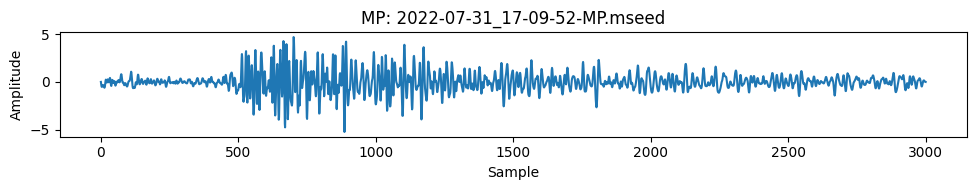

E:\Skripsi\DEC\dataset\ae-supervised-dataset\cleaned-3type\MP\2022-08-01_05-51-16-MP.mseed


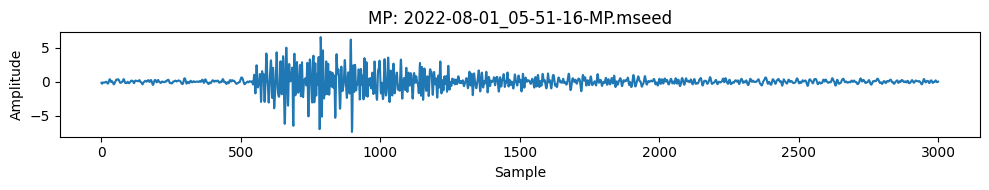

----------------------------------------
Label: ROCKFALL
E:\Skripsi\DEC\dataset\ae-supervised-dataset\cleaned-3type\ROCKFALL\2022-07-31_17-17-05-ROCKFALL.mseed


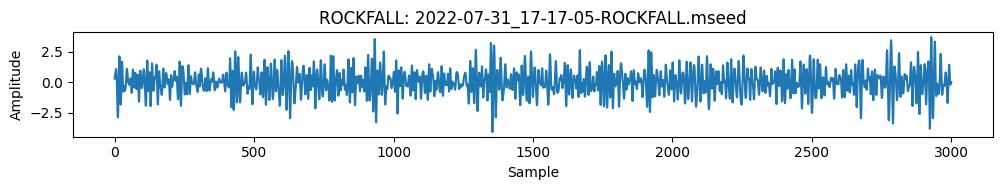

E:\Skripsi\DEC\dataset\ae-supervised-dataset\cleaned-3type\ROCKFALL\2022-07-31_17-26-12-ROCKFALL.mseed


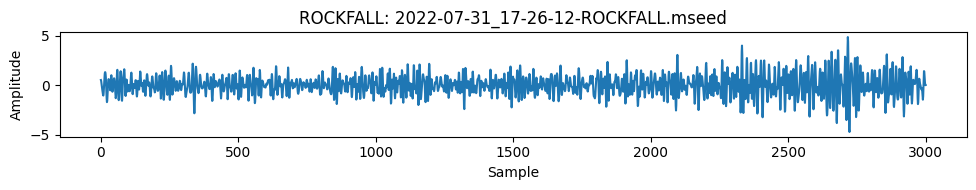

----------------------------------------
Label: VTB
E:\Skripsi\DEC\dataset\ae-supervised-dataset\cleaned-3type\VTB\2022-08-03_13-39-17-VTB.mseed


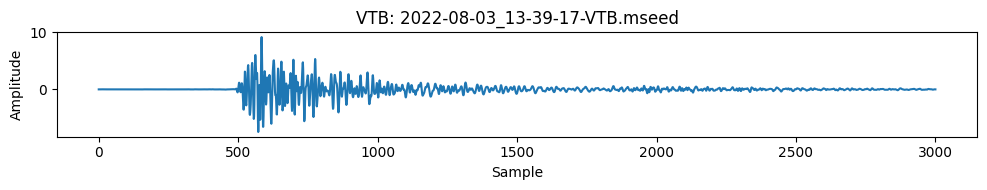

E:\Skripsi\DEC\dataset\ae-supervised-dataset\cleaned-3type\VTB\2022-08-04_06-34-52-VTB.mseed


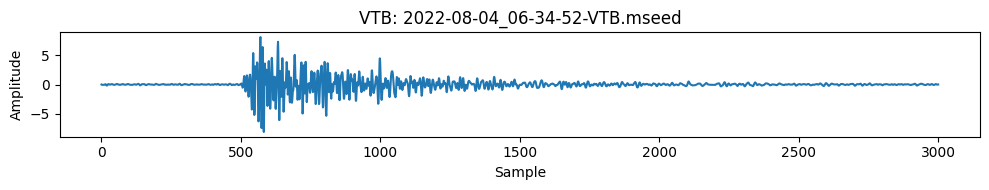

----------------------------------------


In [12]:
files_per_label = manifest.groupby('label').head(2)
for label, group in files_per_label.groupby('label'):
    print(f"Label: {label}")
    for path in group['path']:
        print(path)
        # Plot waveform
        st = read(path)
        tr = st[0]
        plt.figure(figsize=(10, 2))
        plt.plot(tr.data)
        plt.title(f"{label}: {os.path.basename(path)}")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()
    print("-" * 40)
